In [54]:
#import libraries
import pandas as pd

In [55]:
#Import database
stocks_data = pd.read_csv("stocks.csv")
print(stocks_data.head())

  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  


### The dataset consists of the following columns:

1. Ticker: The stock symbol.
2. Date: The date of the trading session.
3. Open: The opening price of the stock for the trading session.
4. High: The highest price of the stock during the trading session.
5. Low: The lowest price of the stock during the trading session.
6. Close: The closing price of the stock for the trading session.
7. Adj Close: The adjusted closing price of the stock (adjusted for things like dividends and stock splits).
8. Volume: The number of shares traded during the trading session.

### Next, I will perform the following tasks for Data Preparation:

- Check for missing values in the dataset.
- Convert the Date column to a datetime type for time series analysis.
- Check how many unique stocks (Tickers) are present and their respective data points.
- Resample the data to a consistent time frequency if necessary (e.g., daily, weekly), based on the data’s current granularity and the forecasting goals.

In [58]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])

missing_values = stocks_data.isnull().sum()

unique_stocks = stocks_data['Ticker'].value_counts()

print(missing_values)

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [59]:
print(unique_stocks)

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64


There are no missing values in the dataset, which is great. The dataset contains data for four unique stocks: Apple (AAPL), Microsoft (MSFT), Netflix (NFLX), and Google (GOOG), each with 62 data points.

Now, to explore the dataset, let’s:

Check the time range of the dataset.
Visualize the closing price trends for each stock.

In [62]:
time_range = stocks_data['Date'].min(), stocks_data['Date'].max()
print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


The dataset spans from February 7, 2023, to May 5, 2023, covering roughly three months. Given the short time period, we will focus on visualizing the closing price trends to gain a better understanding of the data. Next, let's plot the closing price trends for each of the four stocks.

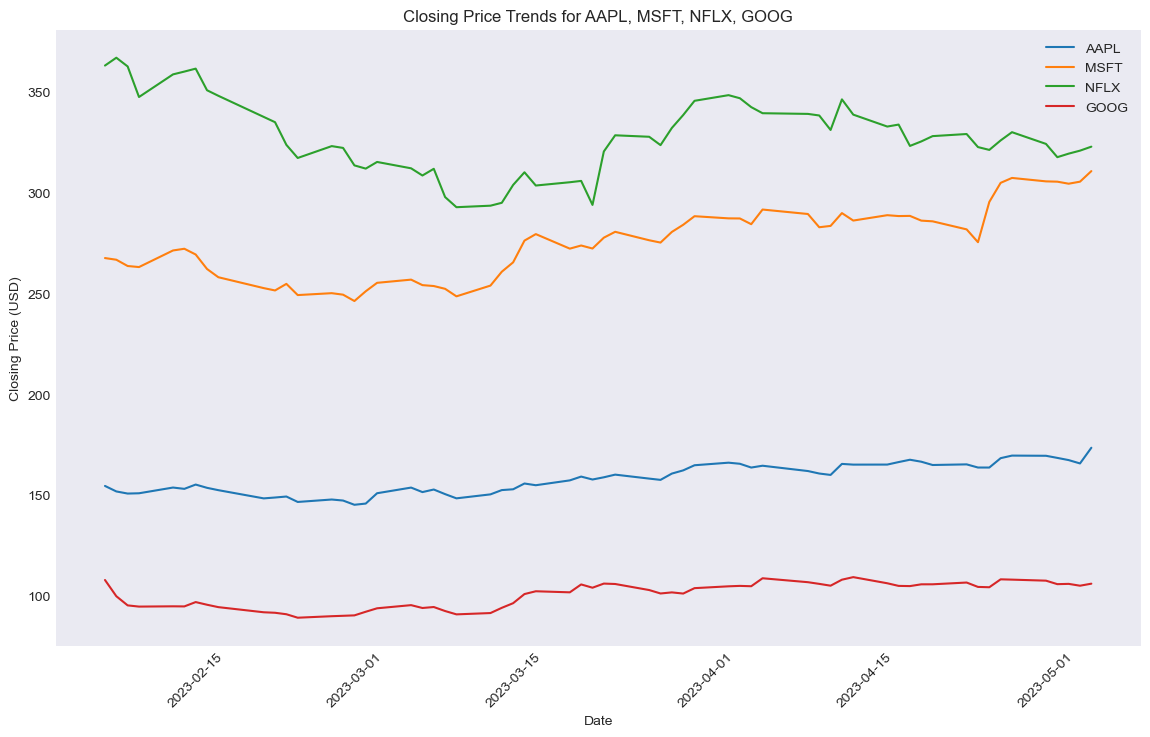

In [64]:
#!pip install seaborn
import matplotlib.pyplot as plt
#print(plt.style.available)

plt.style.use('seaborn-v0_8-dark')

fig, ax = plt.subplots(figsize=(14, 8))

for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Close'], label=ticker)

ax.set_title('Closing Price Trends for AAPL, MSFT, NFLX, GOOG')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

The above plot shows the closing price trends for Apple (AAPL), Microsoft (MSFT), Netflix (NFLX), and Google (GOOG) over the three months from February 2023 to May 2023. Each stock exhibits its pattern of fluctuations over this time.

## Model Selection and Data Preparation

Next, for model selection, given the multivariate nature of our data, a Vector AutoRegression (VAR) model seems like a suitable option. VAR models are effective in capturing the linear relationships between multiple time series, making them ideal for forecasting the prices of several stocks at once.

Before moving forward with VAR modeling, it’s crucial to confirm that the time series data for each stock is stationary. Since VAR models require stationarity, we need to ensure that the statistical properties (mean, variance) of the series remain constant over time. To do so, we’ll follow these steps:

- Use the Augmented Dickey-Fuller (ADF) test for each stock’s closing price.
- Depending on the ADF test results, we may need to transform the data (e.g., by differencing) to achieve stationarity.
- Train the VAR model and forecast the future values.

## We’ll start with the ADF test for stationarity

In [70]:
from statsmodels.tsa.stattools import adfuller

# function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')  # ADF test
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string()) 
    print('\n')

# perform ADF test on the 'Close' price of each stock
for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Close']
    adf_test(series, title=ticker)

ADF Test on "AAPL"
ADF Test Statistic             -0.291693
p-value                         0.926673
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "MSFT"
ADF Test Statistic             -0.149807
p-value                         0.944246
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "NFLX"
ADF Test Statistic             -2.150926
p-value                         0.224536
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "GOOG"
ADF Test Statistic             -1.431504
p-value         

### The Augmented Dickey-Fuller (ADF) test results for each stock’s closing price indicate:

- AAPL: The p-value is 0.927, suggesting we failed to reject the null hypothesis, and the series is non-stationary.
- MSFT: With a p-value of 0.944, this series is also non-stationary.
- NFLX: The p-value is 0.225, indicating non-stationarity.
- GOOG: The p-value is 0.567, again indicating non-stationarity.

Since all the series are non-stationary, we need to make them stationary before proceeding with the modeling. A common approach to achieve this is to difference the series. Differencing involves transforming the data to represent the change from one period to the next, rather than the absolute values. This method helps stabilize the mean and variance of the time series, making it suitable for modeling with a VAR approach.

Let’s make the series stationary by differencing the closing prices of each stock and then re-testing for stationarity

In [74]:
# differencing the 'Close' price of each stock to make the series stationary
stocks_data['Diff_Close'] = stocks_data.groupby('Ticker')['Close'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_Close'].dropna()
    adf_test(series, title=f"{ticker} - Differenced")

ADF Test on "AAPL - Differenced"
ADF Test Statistic             -5.238104
p-value                         0.000007
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137


ADF Test on "MSFT - Differenced"
ADF Test Statistic            -5.895024e+00
p-value                        2.864876e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00


ADF Test on "NFLX - Differenced"
ADF Test Statistic            -8.022480e+00
p-value                        2.058613e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.59319

After differencing the closing prices, the Augmented Dickey-Fuller (ADF) test results for each differenced series are:

- AAPL – Differenced: The p-value is significantly less than 0.05, indicating that we can reject the null hypothesis. The series is stationary.
- MSFT – Differenced: Similarly, the p-value is significantly low, confirming stationarity.
- NFLX – Differenced: With a very low p-value, this series is also stationary.
- GOOG – Differenced: This series is stationary as well, indicated by a very low p-value.
- All differenced series are now stationary, which makes them suitable for VAR modelling for Multivariate Time Series Forecasting.

## Model Training

Since we’re working with a relatively small dataset and a short time frame, we’ll proceed with training a VAR model on the entire dataset:m

In [79]:
from statsmodels.tsa.vector_ar.var_model import VAR

# prepare the dataset for VAR model
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_Close').dropna()

model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5

forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)

forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['Close'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  174.369001  113.624024  320.179608  327.604320
2023-05-07  169.684437  104.915080  318.416783  342.704109
2023-05-08  168.190894  107.828473  329.210732  367.542312
2023-05-09  160.836027   99.287041  326.849012  348.088074
2023-05-10  167.645928  101.392914  317.986680  387.059442


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The forecasted closing prices for each stock over the next 5 days have been successfully computed. These forecasts reverse the differencing process to present the expected closing prices in their original scale. To conclude, we will visualize both the historical closing prices and the forecasted prices for each stock on a single graph. This will allow us to see the forecast in relation to recent trends, providing a clear view of how the prices are expected to evolve.

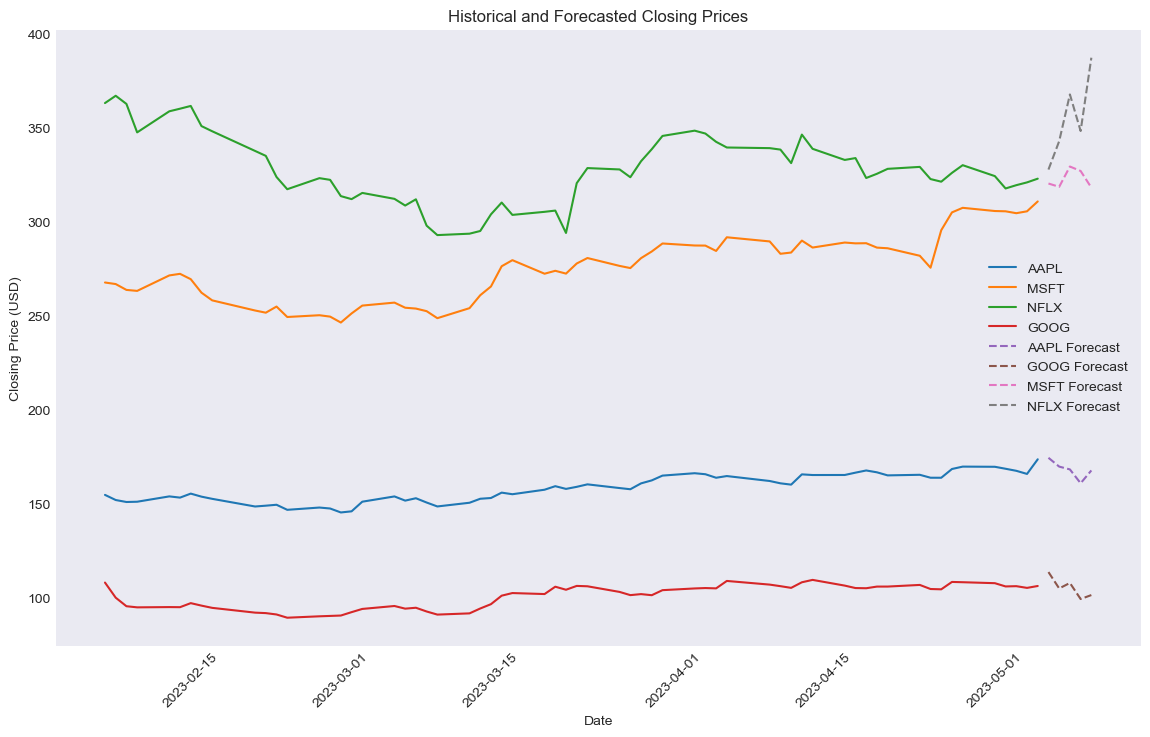

In [81]:
fig, ax = plt.subplots(figsize=(14, 8))

# plot historical closing prices for each stock
for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Close'], label=ticker)

# plot the forecasted closing prices
for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

This is how you can perform Multivariate Time Series Forecasting using Python. Multivariate Time Series Forecasting is especially useful when the variables exhibit dependencies or interactions with each other. The goal is to capture these interdependencies to make accurate predictions for each variable over a future time period. By using models like Vector AutoRegression (VAR), we can leverage the relationships between multiple time series to improve the forecasting accuracy and better understand how different variables influence each other over time.